In [1]:
import gym
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import copy 
from statistics import mean

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T



In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward','next_state'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    
BATCH_SIZE = 32
GAMMA = 0.99
EPS_START = 0.95
EPS_END = 0.01
EPS_DECAY = 400
TARGET_UPDATE = 10
CAPACITY=10000

class net(nn.Module):

    def __init__(self, num_states,mid,num_actions):
        super(net, self).__init__()
        self.fc1 = nn.Linear(num_states, mid)
        self.fc2 = nn.Linear(mid, mid)
        self.fc3 = nn.Linear(mid, num_actions)
    
    def forward(self, x):
        h1 = F.relu(self.fc1(x)) 
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

class DDQN:
    def __init__(self,num_states,mid,num_actions):
        self.num_states=num_states
        self.num_actions=num_actions
        self.memory=ReplayMemory(CAPACITY)
        self.q_network=net(num_states,mid,num_actions)
        self.q_network.optimizer=optim.Adam(self.q_network.parameters(),lr=.0001)
        self.target_q_network=self.q_network
        self.loss_history=[]
        self.action_type=None
        
        
    def replay(self):
        if len(self.memory)<BATCH_SIZE:
            return
        self.batch, self.state_batch,self.action_batch,self.reward_batch,self.non_final_next_state_batch = self.make_minibatch()
        self.expected_state_action_values=self.get_expected_state_action_values()
        
    def get_action(self,state,steps_done):
        epsilon = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
        #epsilon = .5 /(steps_done+1)
        sample = random.random()

        if epsilon < sample:
            self.q_network.eval()
            with torch.no_grad():
                action=torch.argmax(self.q_network(state)).unsqueeze(0)
                self.action_type="Q"
        else:
            action=torch.LongTensor([random.randrange(self.num_actions)])
            self.action_type="random"
        return action
    def make_minibatch(self):
        transitions=self.memory.sample(BATCH_SIZE)
        batch=Transition(*zip(*transitions))
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        #next_state_batch=torch.cat(batch.next_state)#torch.stack(list(batch.next_state), dim=0)
        non_final_next_state_batch = torch.cat([s for s in batch.next_state if s is not None])
        return batch,state_batch,action_batch,reward_batch,  non_final_next_state_batch

    def get_expected_state_action_values(self):
        self.q_network.eval()
        self.target_q_network.eval()
        state_action_values=self.q_network(self.state_batch).gather(1,self.action_batch.unsqueeze(1))
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,self.batch.next_state)),dtype=bool)
        next_state_values= torch.zeros(BATCH_SIZE).unsqueeze(1)
        a_m=torch.zeros(BATCH_SIZE).type(torch.LongTensor)
        a_m[non_final_mask]=self.q_network(self.non_final_next_state_batch).detach().argmax(axis=1)
        a_m_non_final_next_states=a_m[non_final_mask].unsqueeze(1)
        next_state_values[non_final_mask]= self.target_q_network(self.non_final_next_state_batch).gather(1,a_m_non_final_next_states)
        expected_state_action_values = self.reward_batch + GAMMA*next_state_values
        self.q_network.train()
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values) 
        self.loss_history.append(loss.item())
        self.q_network.optimizer.zero_grad()
        loss.backward()
        self.q_network.optimizer.step()
        return expected_state_action_values 

    
  

In [7]:
env=gym.make('CartPole-v1')
complete_episode=0
policy_net = DDQN(4,128,2)
print("Show max, min and mean every 100 episodes.")
print("episode max min mean")

max=0
history=[]
mean_tmp=[]
mean_history=[]
min=500

for episode in range(3000):
  step=0
  done=False
  state = env.reset()
  state=torch.from_numpy(state).float().unsqueeze(0)


  while not done:
    step+=1
    action = policy_net.get_action(state,episode)
    next_state,reward,done,_=env.step(action.item())
    next_state = torch.from_numpy(next_state).float().unsqueeze(0)
    if done:
      next_state=None
      if step>200:
        complete_episode+=1
      else:
        complete_episode=0

    reward=torch.tensor([reward]).float().unsqueeze(0)
    policy_net.memory.push(state, action, reward, next_state)
    state=next_state

    policy_net.replay()
  history.append(step)
  mean_tmp.append(step)

  if step>max:
    max=step
  if step<min:
    min=step

 
  if (episode+1) %100==0 and episode!=0:
    mean100=mean(mean_tmp)
    mean_history.append(mean100)
    print(" ",episode+1," ", max," ",min,mean100)
    mean_tmp=[]
    max=0   
    min=500




    

Show max, min and mean every 100 episodes.
episode max min mean
  100   54   9 20.32
  200   88   10 22.94
  300   113   10 30.07
  400   151   10 47.58
  500   172   11 71.42
  600   304   13 116.42
  700   500   36 295.93
  800   500   76 455.42
  900   500   34 460.33
  1000   500   69 487.48
  1100   500   68 481.77
  1200   500   110 492.99
  1300   500   235 497.1
  1400   500   500 500
  1500   500   500 500
  1600   500   500 500
  1700   500   49 479.95
  1800   500   129 483.31
  1900   500   157 496.57
  2000   500   500 500
  2100   500   214 497.14
  2200   500   500 500
  2300   500   39 491.82
  2400   500   500 500
  2500   500   500 500
  2600   500   500 500
  2700   500   128 490.02
  2800   500   133 485.53
  2900   500   151 493.98
  3000   500   21 491.01


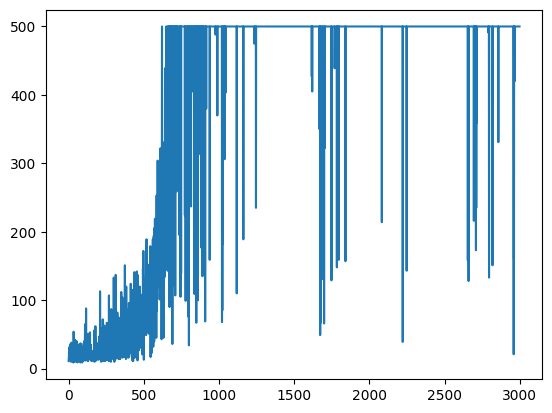

In [16]:
y=history
x=range(0,len(y))
plt.plot(x,y)
plt.show()

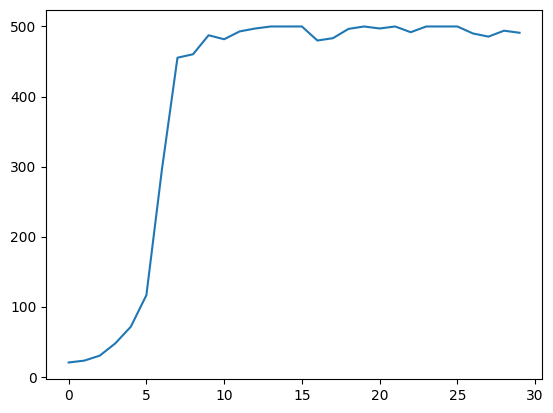

In [17]:
y=mean_history
x=range(0,len(y))
plt.plot(x,y)
plt.show()